In [1]:
!pip install torch torchvision


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [3]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load the training dataset
train_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True)

# Download and load the test dataset
test_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=False, transform=transform, download=True)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=64, shuffle=False)

# Check dataset shape
print(f"Training data: {len(train_dataset)} samples")
print(f"Testing data: {len(test_dataset)} samples")


100%|██████████| 26.4M/26.4M [00:01<00:00, 16.9MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 272kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.08MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 17.3MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Training data: 60000 samples
Testing data: 10000 samples


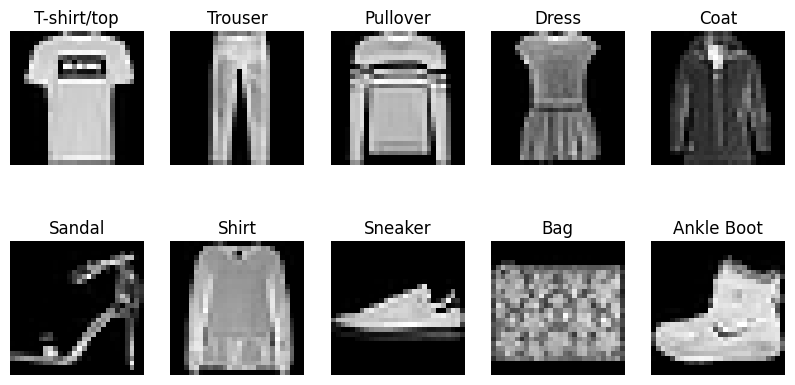

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Define class labels
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"
]

# Create a dictionary to store images for each class
class_images = {}

# Loop through the dataset and store one image per class
for image, label in train_dataset:
    if label not in class_images:
        class_images[label] = image
    if len(class_images) == 10:  # Stop once we have one image per class
        break

# Plot images
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    img = class_images[i].squeeze().numpy()  # Remove channel dimension
    plt.imshow(img, cmap="gray")
    plt.title(class_names[i])
    plt.axis("off")

plt.show()


In [21]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(12544, 128)  # Change from 3136 to 12544
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))

        # print(f"Shape before flattening: {x.shape}")  # Debugging
        x = torch.flatten(x, start_dim=1)
        # print(f"Shape after flattening: {x.shape}")  # Debugging

        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x




In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [23]:
num_epochs = 10  # Set number of epochs

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        # print(f"Model Output Shape: {outputs.shape}")
        # print(f"Labels Shape: {labels.shape}")
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

print("Training complete.")


Epoch 1/10, Loss: 0.4010
Epoch 2/10, Loss: 0.2524
Epoch 3/10, Loss: 0.2010
Epoch 4/10, Loss: 0.1623
Epoch 5/10, Loss: 0.1338
Epoch 6/10, Loss: 0.1075
Epoch 7/10, Loss: 0.0877
Epoch 8/10, Loss: 0.0735
Epoch 9/10, Loss: 0.0619
Epoch 10/10, Loss: 0.0518
Training complete.


In [24]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 92.55%


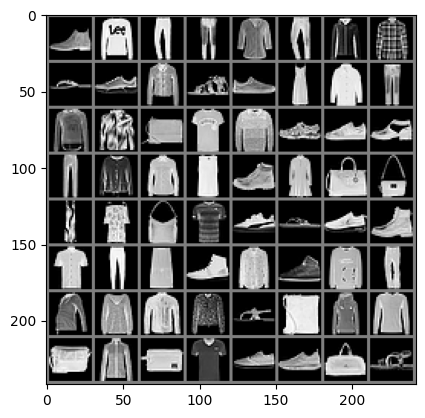

Predicted:  [9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 6, 8, 0, 2, 5, 7, 5, 1, 6, 6, 0, 9, 3, 8, 8, 1, 3, 8, 0, 7, 5, 7, 9, 6, 1, 4, 9, 6, 7, 2, 1, 2, 2, 4, 4, 5, 8, 2, 2, 8, 4, 8, 0, 7, 7, 8, 5]


In [26]:
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

# Get some test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Predict
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Show images
imshow(torchvision.utils.make_grid(images.cpu()))
print("Predicted: ", [pred.item() for pred in predicted[:]])
